<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# <h1 align="center" id="heading">Subscription Prediction with Delta Lake, PySpark, and MLlib</h1>

# Spark Environment

Make sure that you open this notebook in your Spark environment!

In [ ]:
# !pip install -U -q pyspark delta-spark # If you use Colab uncomment this line

## Learning Objectives

At the end of this session, you will be able to 

- Load, save, partition data with Delta Lake tables
- Explore data with Spark DataFrames 
- Build a pipeline in MLlib for machine learning workflow
- Fit a logistic regression model, make predictions, and evaluate the model

## Part 1: Data Loader

We are using a dataset from the UCI Machine Learning Repository.

1. Use `wget` to download the dataset. Then use `ls` to verify that the `bank.zip` file is downloaded.

In [ ]:
%%sh
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

--2023-01-19 20:59:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip’

     0K .......... .......... .......... .......... ..........  8%  360K 1s
    50K .......... .......... .......... .......... .......... 17%  364K 1s
   100K .......... .......... .......... .......... .......... 26% 67.9M 1s
   150K .......... .......... .......... .......... .......... 35%  733K 1s
   200K .......... .......... .......... .......... .......... 44% 63.7M 0s
   250K .......... .......... .......... .......... .......... 53% 81.6M 0s
   300K .......... .......... .......... .......... .......... 61%  741K 0s
   350K .......... .......... .......... .......... .......... 70% 76.3M 0s
   400K ........

In [ ]:
ls

azure/    conf/       hadoop_accessed_config.lst*  preload_class.lst*
bank.zip  eventlogs/  logs/


2. Unzip the file and use `ls` to see the files.

In [ ]:
%%sh
unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [ ]:
ls -lh

total 6.7M
drwxr-xr-x 2 root root 4.0K Jan 19 20:55 azure/
-rw-r--r-- 1 root root 4.4M Feb 14  2012 bank-full.csv
-rw-r--r-- 1 root root 3.8K Feb 14  2012 bank-names.txt
-rw-r--r-- 1 root root 451K Feb 14  2012 bank.csv
-rw-r--r-- 1 root root 566K Feb 14  2012 bank.zip
drwxr-xr-x 2 root root 4.0K Jan 19 20:55 conf/
drwxr-xr-x 3 root root 4.0K Jan 19 20:57 eventlogs/
-r-xr-xr-x 1 root root 3.0K Jan 19 20:55 hadoop_accessed_config.lst*
drwxr-xr-x 2 root root 4.0K Jan 19 20:58 logs/
-r-xr-xr-x 1 root root 1.3M Jan 19 20:55 preload_class.lst*


3. Inspect the dataset and note if there is anything to be aware of in the dataset structure.

In [ ]:
%%sh
wc -l bank.csv

4522 bank.csv


In [ ]:
%%sh
head bank.csv

"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
30;"unemployed";"married";"primary";"no";1787;"no";"no";"cellular";19;"oct";79;1;-1;0;"unknown";"no"
33;"services";"married";"secondary";"no";4789;"yes";"yes";"cellular";11;"may";220;1;339;4;"failure";"no"
35;"management";"single";"tertiary";"no";1350;"yes";"no";"cellular";16;"apr";185;1;330;1;"failure";"no"
30;"management";"married";"tertiary";"no";1476;"yes";"yes";"unknown";3;"jun";199;4;-1;0;"unknown";"no"
59;"blue-collar";"married";"secondary";"no";0;"yes";"no";"unknown";5;"may";226;1;-1;0;"unknown";"no"
35;"management";"single";"tertiary";"no";747;"no";"no";"cellular";23;"feb";141;2;176;3;"failure";"no"
36;"self-employed";"married";"tertiary";"no";307;"yes";"no";"cellular";14;"may";341;1;330;2;"other";"no"
39;"technician";"married";"secondary";"no";147;"yes";"no";"cellular";6;"may";151;2;-1;0;"unknown";"no"
41;"entrepreneur";"marrie

4. Create a Delta table for `bank.csv` (Why Delta Lake? Here's a read [here](https://medium.com/@databeans-blogs/delta-lake-the-data-engineers-missing-piece-part-1-ebab66a3f8c0?source) from a data engineer's perspective)

    We first set up a Python project `ml-bank`, configure the SparkSession with the `configure_spark_with_delta_pip()` utility function in Delta Lake:

In [ ]:
import pyspark
from delta import *

builder = pyspark.sql.SparkSession.builder.appName("ml-bank") \
  .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
  .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

5. We define output formats and paths, you need to complete code to load the data from its source (since the delimiter of the file is semicolon, use [`spark.read.csv`](https://spark.apache.org/docs/latest/sql-data-sources-csv.html) that provides more flexibility) and write the data to its target (hint: [Create a table](https://docs.databricks.com/delta/delta-batch.html)).


__NOTE__ Databricks requires all the paths to be absolute, not relative. To check the absolute path, run `pwd` bash command.

In [ ]:
# Define the input and output formats and paths and the table name.
write_format = 'delta'
load_path = 'file:/databricks/driver/bank.csv'
save_path = 'file:/databricks/driver/tmp/delta/bank-4k'
table_name = 'default.bank4k'

# Load the data from its source into a dataframe.
df = spark.read.option('header', True).option('delimiter', ';').csv(load_path)

# Create table with path using DataFrame's schema and write data to it
# Note if you are overwriting to specificy overwrite option
df.write.option('mergeSchema', True).saveAsTable(table_name, mode='overwrite', path=save_path)

6. Verify what we just created.

In [ ]:
ls -lh /databricks/driver/tmp/delta/bank-4k/

total 64K
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 _delta_log/
-rw-r--r-- 1 root root  59K Jan 19 21:00 part-00000-85cff807-f03b-4401-afda-f1238161436c-c000.snappy.parquet


7. Partition data by `job` status. 

  To speed up queries that have predicates involving the partition columns, we should partition data. Often time, we partition by anonymized user id; here we demonstrate the idea with `job`.

__NOTE__ We saw previously that the data can be loaded in Delta lake as one table. Now to partition the data, we need to remove the existing directory, or load it into a different directoty. The goal is to showcase delta lake capabilities.

In [ ]:
import shutil
shutil.rmtree('/databricks/driver/tmp/delta/bank-4k') # To replace data, we need to remove the existing directory

In [ ]:
partition_by = 'job'

# Write the data to its target.
df.write.option('header', True).partitionBy(partition_by).mode('overwrite').csv(save_path)

In [ ]:
ls -lh /databricks/driver/tmp/delta/bank-4k/

total 48K
-rw-r--r-- 1 root root    0 Jan 19 21:00  _SUCCESS
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=admin.'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=blue-collar'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=entrepreneur'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=housemaid'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=management'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=retired'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=self-employed'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=services'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=student'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=technician'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=unemployed'/
drwxr-xr-x 2 root root 4.0K Jan 19 21:00 'job=unknown'/


We only touch the surface of Delta Lake, for more information, check [Delta Lake guide](https://docs.databricks.com/delta/index.html)

## Part 2: Exploring The Data

We will use the direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit.

1. Load data from its source by specifying the data format and path; then check out the schemas.

In [ ]:
read_format = 'delta'
load_path = '/tmp/delta/bank-4k/'

df = spark.read.format(read_format).load(load_path) 

df.printSchema()

root
 |-- age: string (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- campaign: string (nullable = true)
 |-- pdays: string (nullable = true)
 |-- previous: string (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



Here are the columns you should see:

* Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome

* Output variable: y (deposit)

2. Have a peek of the first five observations. Use the `.show()` method.

In [ ]:
df.show(5)

+---+------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|   job| marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 43|admin.| married|secondary|     no|    264|    yes|  no|cellular| 17|  apr|     113|       2|   -1|       0| unknown| no|
| 37|admin.|  single| tertiary|     no|   2317|    yes|  no|cellular| 20|  apr|     114|       1|  152|       2| failure| no|
| 53|admin.| married|secondary|     no|    105|     no| yes|cellular| 21|  aug|      74|       2|   -1|       0| unknown| no|
| 42|admin.|divorced|secondary|     no|   1811|    yes|  no| unknown| 14|  may|     150|       1|   -1|       0| unknown| no|
| 61|admin.| married|  unknown|     no|   4629|    yes|  no|cellular| 27|  jan|     181|       1|   92|       1| succe

To get a prettier result, it can be nice to use Pandas to display our DataFrame. Use the Spark `.take()` method to get the first 5 rows and then convert to a pandas DataFrame. Don't forget to pass along the column names. You should see the same result as above, but in a more aesthetically appealing format.

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import Row

row_pandas_session = SparkSession.builder.appName('row_pandas_session').getOrCreate()
row_object_list = df.take(5)

short_df = row_pandas_session.createDataFrame(row_object_list)
pandas_df = short_df.toPandas()
print(pandas_df)

  age     job   marital  education default balance housing loan   contact day  \
0  43  admin.   married  secondary      no     264     yes   no  cellular  17   
1  37  admin.    single   tertiary      no    2317     yes   no  cellular  20   
2  53  admin.   married  secondary      no     105      no  yes  cellular  21   
3  42  admin.  divorced  secondary      no    1811     yes   no   unknown  14   
4  61  admin.   married    unknown      no    4629     yes   no  cellular  27   

  month duration campaign pdays previous poutcome    y  
0   apr      113        2    -1        0  unknown   no  
1   apr      114        1   152        2  failure   no  
2   aug       74        2    -1        0  unknown   no  
3   may      150        1    -1        0  unknown   no  
4   jan      181        1    92        1  success  yes  


3. We can also perform transformations on our DataFrame using the Pandas commands that we know and love using the [Pandas on Spark API](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html) **(new on Spark versions >= 3.2)**.  Pandas on Spark API was born out of the Databricks project, Koalas 🐨, allows us to use the Pandas commands and aesthetically pleasing output that we know and love distributed on the speed and scale of Spark!  For a nice quickstart on Pandas on Spark, check out this [article](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)!  Let's convert our Spark DataFrame to a Pandas on Spark DataFrame!

In [ ]:
import pyspark.pandas as ps

psdf = df.pandas_api()
psdf.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
2,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
3,40,management,married,tertiary,no,194,no,yes,cellular,29,aug,189,2,-1,0,unknown,no
4,38,management,divorced,unknown,no,0,yes,no,cellular,18,nov,96,2,-1,0,unknown,no


4. How many datapoints are there in the dataset? Use the `.count()` method.

In [ ]:
psdf.count()

Out[32]: age          4521
job          4521
marital      4521
education    4521
default      4521
balance      4521
housing      4521
loan         4521
contact      4521
day          4521
month        4521
duration     4521
campaign     4521
pdays        4521
previous     4521
poutcome     4521
y            4521
dtype: int64

5. Use the `.describe()` method to see summary statistics on the features.

In [ ]:
psdf.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,67,12,3,4,2,2353,2,2,3,31,12,875,32,292,24,4,2
top,34,management,married,secondary,no,0,yes,no,cellular,20,may,123,1,-1,0,unknown,no
freq,231,969,2797,2306,4445,357,2559,3830,2896,257,1398,27,1734,3705,3705,3705,4000


6. The above result includes the columns that are categorical, so those columns don't have useful summary statistics. Let's inspect just the numeric features.

    `numeric_features` is defined below to contain the column names of the numeric features.  Notice we use the `zip` functions to iterate through two lists at the same time!
    
    Filter the DataFrame as you would in pandas to select only the numeric features from the DataFrame and then get the summary statistics on the resulting DataFrame as we did above.

In [ ]:
"""bank.csv only loads strings. let's convert this to int32"""
psdf = psdf.astype({"age":"int32","balance":"int32","day":"int32","duration":"int32","pdays":"int32"})


In [ ]:
col_names = [name for name in psdf.dtypes.index]
dtypes = [dtype for dtype in psdf.dtypes.tolist()]

numeric_features = [name for name, dtype in zip(col_names, dtypes) if dtype == 'int32']
psdf.filter(items=numeric_features).describe()

,age,balance,day,duration,pdays
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,39.766645
std,10.576211,3009.638142,8.247667,259.856633,100.121124
min,19.000000,-3313.000000,1.000000,4.000000,-1.000000
25%,33.000000,69.000000,9.000000,104.000000,-1.000000
50%,39.000000,444.000000,16.000000,185.000000,-1.000000
75%,49.000000,1480.000000,21.000000,329.000000,-1.000000
max,87.000000,71188.000000,31.000000,3025.000000,871.000000


7. Run the following code to look at correlation between the numeric features.  Let's convert our Pandas on Spark DataFrame to a Pandas DataFrame using the `to_pandas()` command. This will enable us to plot the data.  What do you see?

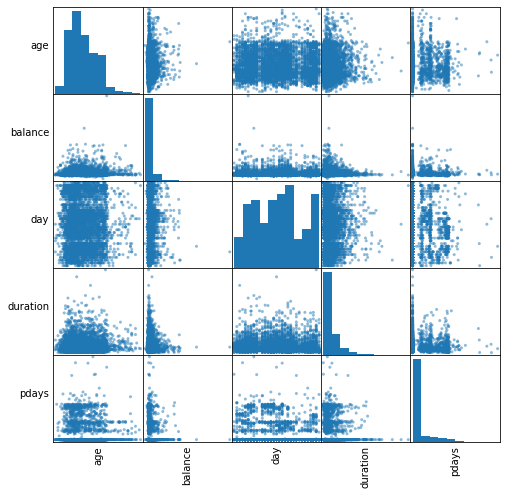

In [ ]:
# Convert Pandas on Spark DataFrame to Spark DataFrame
numeric_data = psdf[numeric_features].to_pandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
    
# the graphs don't show clear correlations

There aren't any highly correlated variables, implying that we can keep them all for the model. However, day and month columns are not really useful, so will remove these two columns.

8. Use the `.drop()` method to remove the `month` and `day` columns.
    
    Note that this method returns a new DataFrame, so save that result as `sdf`.

    Use the `.dtypes` method to verify that `sdf` now has the correct columns.

In [ ]:
sdf = psdf.drop(['day', 'month'], axis=1)
sdf.dtypes

Out[57]: age           int32
job          object
marital      object
education    object
default      object
balance       int32
housing      object
loan         object
contact      object
duration      int32
campaign     object
pdays         int32
previous     object
poutcome     object
y            object
dtype: object

## Part 3: Preparing Data for Training a Model

What follows is something analagous to a dataloader pipeline in Tensorflow--we're going to chain together some transformations that will convert our categorical variables into a one-hot format more amenable to training a machine learning model. 
The next code cell just sets this all up, but it doesn't run these transformations on our data yet.

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformation that merges multiple columns into a vector column.

The code is taken from [databricks’ official site](https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example) and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. 
The resulting output has the binary vectors appended to the end of each row. 
We use the StringIndexer again to encode our labels to label indices. 
Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

1. Complete the code by completing the assignment of `assembler`. Use `VectorAssembler` and pass in `assemblerInputs` as `inputCols` and name the `outputCol` `"features"`.

In [ ]:
from pyspark.ml.feature import OneHotEncoder , StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages += [assembler]

## Part 4: Pipeline

We use Pipeline to chain multiple transformations and estimators together to specify our machine learning workflow. 
A Pipeline’s stages are specified as an ordered array.  
To run the pipeline on our Pandas on Spark DataFrame, we will convert it back to a Spark DataFrame using the **`to_spark()`** command

1. Fit a pipeline on df.

In [ ]:
from pyspark.ml import Pipeline
sdf = sdf.to_spark()
pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(sdf)

2. Transform `pipelineModel` on `df` and assign this to variable `transformed_df`.

In [ ]:
from pyspark.sql.types import IntegerType
df = df.withColumn("age", df.age.cast(IntegerType()))
df = df.withColumn("balance", df.balance.cast(IntegerType()))
df = df.withColumn("duration", df.duration.cast(IntegerType()))
df = df.withColumn("campaign", df.campaign.cast(IntegerType()))
df = df.withColumn("pdays", df.pdays.cast(IntegerType()))
df = df.withColumn("previous", df.previous.cast(IntegerType()))

transformed_df = pipelineModel.transform(df)
transformed_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vector

From the transformation, we'd like to take the `label` and `features` columns as well as the original columns from `sdf.`

3. Use the `.select()` method to pull these columns from the `transformed_df` and reassign the resulting DataFrame to `sdf`.

In [ ]:
selectedCols = ['label', 'features'] + sdf.columns
sdf = transformed_df.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



4. Let's view the first five rows of the `sdf` DataFrame using the methods we learned in Part 2:
    * `.show()` method
    * `.take()` method and convert result to a Pandas DataFrame

In [ ]:
# there is a probably a simpler way to do this
sdf.show()

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import Row

row_pandas_session = SparkSession.builder.appName('row_pandas_session').getOrCreate()
row_object_list = sdf.take(5)

short_df = row_pandas_session.createDataFrame(row_object_list)
pandas_df = short_df.toPandas()
print(pandas_df)

+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+---+
|label|            features|age|       job| marital|education|default|balance|housing|loan|  contact|duration|campaign|pdays|previous|poutcome|  y|
+-----+--------------------+---+----------+--------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+---+
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|   1350|    yes|  no| cellular|     185|       1|  330|       1| failure| no|
|  0.0|(30,[0,11,14,16,1...| 30|management| married| tertiary|     no|   1476|    yes| yes|  unknown|     199|       4|   -1|       0| unknown| no|
|  0.0|(30,[0,12,14,16,1...| 35|management|  single| tertiary|     no|    747|     no|  no| cellular|     141|       2|  176|       3| failure| no|
|  0.0|(30,[0,11,14,16,1...| 40|management| married| tertiary|     no|    194|     no| yes| cellular|     189|  

5. Randomly split the dataset in training and test sets, with 70% of the data in the training set and the remaining 30% in the test set.

    Hint: Call the `.randomSplit()` method.

In [ ]:
train, test = sdf.randomSplit([0.7, 0.3])

6. What are the sizes of the training and test sets?

In [ ]:
print(train.count())
print(test.count())

3160
1361


## Part 5: Logistic Regression Model

Optional:
- You can build a RandomForestClassifier with : from pyspark.ml.classification import RandomForestClassifier
- You can build a Gradient-Boosted Tree Classifier with : from pyspark.ml.classification import GBTClassifier

1. Fit a logistic regression with `featuresCol` as `"features"`, `labelCol` as `"label"` and a `maxIter` of 10.

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features",labelCol="label",maxIter=10)
lrModel = lr.fit(train)

2. We can obtain the coefficients by using logistic regression model’s attributes. Look at the following plot of the beta coefficients.

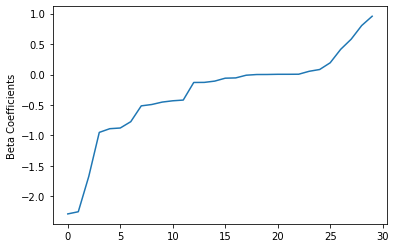

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

3. Use the `.transform()` method to make predictions and save them as `predictions`.

In [ ]:
predictions = lrModel.transform(test)

4. View the first 10 rows of the `predictions` DataFrame.

In [ ]:
predictions.head(10)

Out[92]: [Row(label=0.0, features=SparseVector(30, {0: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 24: 33.0, 25: 4040.0, 26: 132.0, 27: 2.0, 28: -1.0}), age=33, job='management', marital='married', education='secondary', default='no', balance=4040, housing='yes', loan='no', contact='cellular', duration=132, campaign=2, pdays=-1, previous=0, poutcome='unknown', y='no', rawPrediction=DenseVector([3.1124, -3.1124]), probability=DenseVector([0.9574, 0.0426]), prediction=0.0),
 Row(label=0.0, features=SparseVector(30, {0: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 24: 42.0, 25: -105.0, 26: 60.0, 27: 2.0, 28: -1.0}), age=42, job='management', marital='married', education='secondary', default='no', balance=-105, housing='yes', loan='no', contact='cellular', duration=60, campaign=2, pdays=-1, previous=0, poutcome='unknown', y='no', rawPrediction=DenseVector([3.4189, -3.4189]), probability=DenseVector([0.9683, 0.0317]), prediction=0.0),
 Row(labe

5. What is the area under the curve?

    You can find it with the `evaluator.evaluate()` function.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
evaluator.setRawPredictionCol("label")
evaluator.evaluate(test)

Out[90]: 1.0

## OPTIONAL: HyperParameter Tuning a Gradient-Boosted Tree Classifier

1. Fit and make predictions using `GBTClassifier`. The syntax will match what we did above with `LogisticRegression`.

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

2. Perform cross-validation to compare different parameters.

    Note that it can take a while because it's training over many gradient boosted trees. Give it at least 10 minutes to complete.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

## Acknowledgements

This notebook is adapted from [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)